Loading data...
id        0
cat_0     0
cat_1     0
cat_2     0
cat_3     0
cat_4     0
cat_5     0
cat_6     0
cat_7     0
cat_8     0
cat_9     0
cat_10    0
cat_11    0
cat_12    0
cat_13    0
cat_14    0
cat_15    0
cat_16    0
cat_17    0
cat_18    0
cat_19    0
num_0     0
num_1     0
num_2     0
num_3     0
num_4     0
num_5     0
num_6     0
num_7     0
num_8     0
num_9     0
num_10    0
num_11    0
num_12    0
num_13    0
num_14    0
num_15    0
num_16    0
num_17    0
num_18    0
num_19    0
num_20    0
num_21    0
num_22    0
num_23    0
num_24    0
num_25    0
num_26    0
num_27    0
num_28    0
num_29    0
num_30    0
num_31    0
num_32    0
num_33    0
num_34    0
num_35    0
num_36    0
num_37    0
target    0
dtype: int64
Data Loading Time: 3.02 seconds
Preprocessing data...
Data Preprocessing Time: 0.58 seconds
Applying feature selection...
Evaluating with selectkbest__k=50, kneighborsclassifier__n_neighbors=3
ROC AUC: 0.6418438878730042, Accuracy: 0.98560625
Evaluati

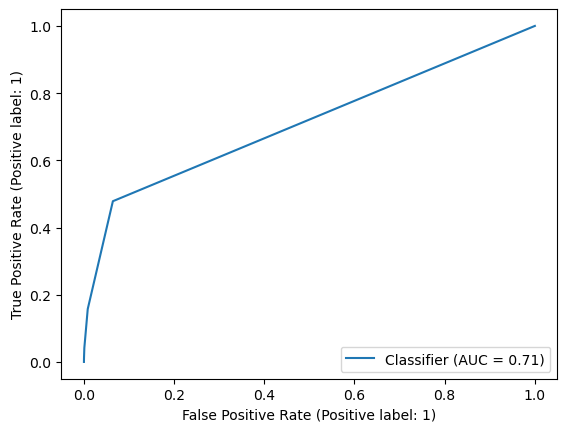

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import faiss

# Record start time
start_time = time.time()

print("Loading data...")
# Load data
data = pd.read_csv('train.csv')

# Check for missing values
print(data.isnull().sum())

# Record data loading time
data_loading_time = time.time()
print(f'Data Loading Time: {data_loading_time - start_time:.2f} seconds')

print("Preprocessing data...")
# Define feature columns
cat_features = [f'cat_{i}' for i in range(20)]
num_features = [f'num_{i}' for i in range(38)]

# Data preprocessing
# Impute and scale numeric features
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Impute and one-hot encode categorical features
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Apply preprocessing steps to the corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

# Split features and target variables
X = data.drop(['id', 'target'], axis=1)
y = data['target'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Record data preprocessing time
data_preprocessing_time = time.time()
print(f'Data Preprocessing Time: {data_preprocessing_time - data_loading_time:.2f} seconds')

print("Applying feature selection...")
# Apply preprocessing to the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Feature selection to reduce dimensionality
selector = SelectKBest(f_classif)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)

# Prepare FAISS index
def train_faiss_knn(X_train, k):
    if not isinstance(X_train, np.ndarray):
        X_train = X_train.todense()  # 将稀疏矩阵转换为密集矩阵
    X_train = X_train.astype(np.float32)  # 转换为float32类型
    index = faiss.IndexFlatL2(X_train.shape[1])
    index.add(X_train)
    return index


def faiss_predict(index, X_test, k):
    if not isinstance(X_test, np.ndarray):
        X_test = X_test.todense()  # 将稀疏矩阵转换为密集矩阵
    X_test = X_test.astype(np.float32)  # 转换为float32类型
    distances, indices = index.search(X_test, k)
    return distances, indices


# Define the parameter grid
param_grid = {
    'selectkbest__k': [50, 100, 150],
    'kneighborsclassifier__n_neighbors': [3, 5, 7]
}

results = []
for k_features in param_grid['selectkbest__k']:
    for k_neighbors in param_grid['kneighborsclassifier__n_neighbors']:
        print(f"Evaluating with selectkbest__k={k_features}, kneighborsclassifier__n_neighbors={k_neighbors}")

        # Update the feature selector
        selector = SelectKBest(f_classif, k=k_features)
        X_train_selected = selector.fit_transform(X_train_transformed, y_train)
        X_test_selected = selector.transform(X_test_transformed)

        # Convert to dense arrays for FAISS
        X_train_selected = X_train_selected.astype(np.float32)
        X_test_selected = X_test_selected.astype(np.float32)

        # Train FAISS KNN
        index = train_faiss_knn(X_train_selected, k_neighbors)

        # Predict
        distances, indices = faiss_predict(index, X_test_selected, k_neighbors)
        y_pred_knn = np.array([np.bincount(y_train[indices[i]].astype(int)).argmax() for i in range(len(indices))])
        y_pred_proba = np.array([np.mean(y_train[indices[i]].astype(int)) for i in range(len(indices))])

        # Evaluate
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred_knn)
        results.append(((k_features, k_neighbors), roc_auc, accuracy))
        print(f"ROC AUC: {roc_auc}, Accuracy: {accuracy}")

# Select the best parameters based on AUC and accuracy
best_by_auc = max(results, key=lambda x: x[1])
best_by_accuracy = max(results, key=lambda x: x[2])
final_best_params = best_by_auc[0] if best_by_auc[1] >= best_by_accuracy[2] else best_by_accuracy[0]

print(f"Final Best Parameters: selectkbest__k={final_best_params[0]}, kneighborsclassifier__n_neighbors={final_best_params[1]}")

# Train and evaluate with the final best parameters
selector = SelectKBest(f_classif, k=final_best_params[0])
X_train_selected = selector.fit_transform(X_train_transformed, y_train)
X_test_selected = selector.transform(X_test_transformed)
X_train_selected = X_train_selected.astype(np.float32)
X_test_selected = X_test_selected.astype(np.float32)
index = train_faiss_knn(X_train_selected, final_best_params[1])
distances, indices = faiss_predict(index, X_test_selected, final_best_params[1])
y_pred_knn = np.array([np.bincount(y_train[indices[i]].astype(int)).argmax() for i in range(len(indices))])
y_pred_proba = np.array([np.mean(y_train[indices[i]].astype(int)) for i in range(len(indices))])

# Record model training time
model_training_time = time.time()
print(f'Model Training Time: {model_training_time - data_preprocessing_time:.2f} seconds')

print("Evaluating model...")
# Evaluate model performance
roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred_knn)
report = classification_report(y_test, y_pred_knn)

# Record end time
end_time = time.time()

# Calculate total run time
run_time = end_time - start_time

print(f'Best Parameters: selectkbest__k={final_best_params[0]}, kneighborsclassifier__n_neighbors={final_best_params[1]}')
print(f'ROC AUC on Test Set: {roc_auc}')
print(f'Accuracy on Test Set: {accuracy}')
print('Classification Report:')
print(report)
print(f'Total Run Time: {run_time:.2f} seconds')

print("Plotting ROC curve...")
# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.show()
